In [1]:
%%html

<h1>misspellings</h1>

<p>Work in Progress</p>

In [2]:
from typing import Iterator

import names
import numpy as np
import pandas as pd

In [3]:
class NameGenerator(object):

    chars:Iterator[str] = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']

    def get_first_name(self) -> str:
        first_name = names.get_first_name()
        while len(first_name) < 3:
            first_name = names.get_first_name()
        return first_name

    def get_middle_initial(self, ends_with_period:bool = True) -> str:
        index = np.random.randint(0, len(self.chars) - 1, size=1, dtype=int)[0]
        initial = self.chars[index]
        if ends_with_period:
            return f"{initial}."

        return initial

    def get_last_name(self) -> str:
        return names.get_last_name()
    
class Perturbation(object):
    
    def tweak(self, text):
        
        l = len(text)
        
        if l == 2:
            return text
        
        swap = np.random.randint(1, len(text)-1)
        
        a = text[swap]
        b = text[swap+1]
        
        return f'{text[0:swap]}{b}{a}{text[swap+2:]}'

In [4]:
### helpers,
generator = NameGenerator()
perturb = Perturbation()

In [5]:
total = 5000

In [6]:
good = []
for _ in range(total):
    fn = generator.get_first_name()
    ln = generator.get_last_name()
    
    fn2 = fn
    ln2 = ln
    
    if np.random.rand() > .5:
        fn2 = perturb.tweak(fn)
    else:
        ln2 = perturb.tweak(ln)
    
    good.append(
        {
            'fn1': f'{fn} {ln}',
            'fn2': f'{fn2} {ln2}',
            'target': 1
        }
    )
    
bad = []
for _ in range(total):
    index1 = np.random.randint(0, total)
    
    index2 = np.random.randint(0, total)
    while index1 == index2:
        index2 = np.random.randint(0, total)

    bad.append(
        {
            'fn1': good[index1]['fn1'],
            'fn2': good[index2]['fn1'],
            'target': 0
        }
    )

In [7]:
dataset = np.concatenate((good, bad), axis=0).tolist()

In [8]:
import Levenshtein

In [9]:
data = pd.DataFrame(dataset).sample(frac=1)
data.head()

,fn1,fn2,target
9282,Jason Lawson,Margie Brunner,0
4688,Chin Kirley,Chin Kirlye,1
3533,Juan Rutherford,Juan Ruthreford,1
6894,Theodore Woods,Titus Shehee,0
555,Harry Quinones,Harry Quinones,1


In [10]:
def calc_levenshtein_distance(row):
    ## 'minimum number of single-character edits'
    return Levenshtein.distance(row['fn1'], row['fn2'])

def calc_hamming_distance(row):
    fn1 = row['fn1']
    fn2 = row['fn2']
    
    if len(fn1) != len(fn2):
        return -2
    
    ## 'simply the number of differing characters'
    return Levenshtein.hamming(fn1, fn2)

def calc_jaro_distance(row):
    ## 'simply the number of differing characters'
    return Levenshtein.jaro(row['fn1'], row['fn2'])

def calc_jaro_winkler_distance(row):
    #giving more weight to common prefix, as spelling mistakes are more likely to occur near ends of words
    return Levenshtein.jaro_winkler(row['fn1'], row['fn2'])

data['lev'] = data.apply(calc_levenshtein_distance, axis = 1)
data['jaro'] = data.apply(calc_jaro_distance, axis = 1)
data['hamming'] = data.apply(calc_hamming_distance, axis = 1)
data['jaro_winkler'] = data.apply(calc_jaro_winkler_distance, axis = 1)

columns = ['lev', 'jaro', 'hamming', 'jaro_winkler']

In [11]:
data.head()

,fn1,fn2,target,lev,jaro,hamming,jaro_winkler
9282,Jason Lawson,Margie Brunner,0,12,0.456349,-2,0.456349
4688,Chin Kirley,Chin Kirlye,1,2,0.969697,2,0.996970
3533,Juan Rutherford,Juan Ruthreford,1,2,0.977778,2,0.997778
6894,Theodore Woods,Titus Shehee,0,13,0.457937,-2,0.512143
555,Harry Quinones,Harry Quinones,1,0,1.000000,0,1.000000


In [12]:
import seaborn as sns

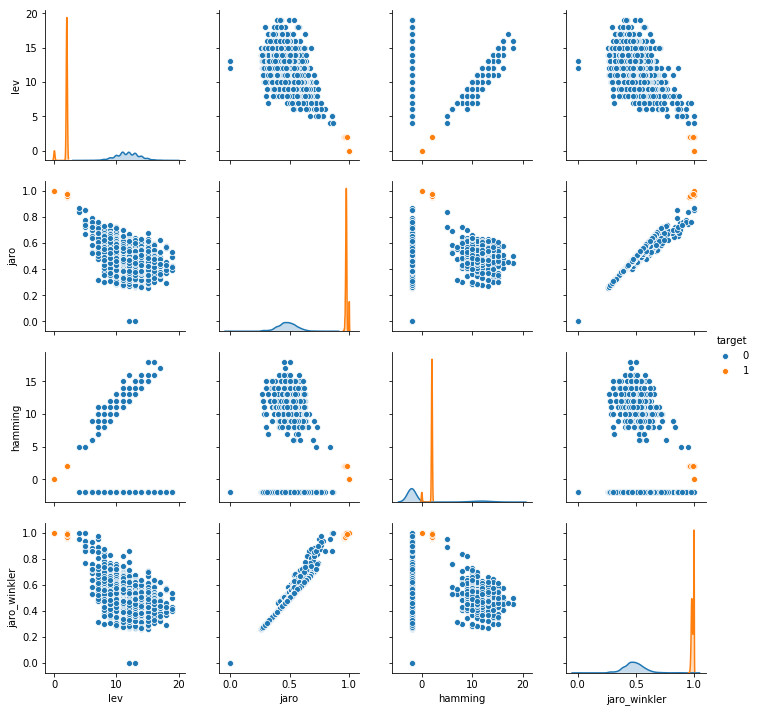

In [13]:
sns.pairplot(data=data, vars = columns, hue='target')

In [14]:
from sklearn import svm
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [15]:
X = data.loc[:, ['lev', 'jaro']]
y = data.loc[:, ['target']]

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [16]:
clf = svm.SVC()

clf.fit(X_train, y_train)

/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [17]:
mean_squared_error(clf.predict(X_test), y_test)

0.0